In [1]:
import sys; sys.path.append('../')

from src.data_loader import load_data
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (10,10)

# Analysis of the final datasets of clusters

In [3]:
clusters, _ = load_data('../data/huge_sample_input_classified.txt')

In [4]:
data = clusters.replace('None', np.nan).dropna(axis=1)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = data.select_dtypes(include=numerics).columns

## Some numbers:

- Number of instances: 5958
- Number of features: 55
- Number of usable features (at least one not null): 42
- Number of numerical features: 40

In [5]:
data.describe()

,x,y,z,n_points,n_order,volume,positive_volume,negative_volume,area,confidence,...,coplanararity_index_mean_origin,coplanararity_index_sigma_origin,colinearity_index_mean_origin,colinearity_index_sigma_origin,coplanararity_index_mean_destination,coplanararity_index_sigma_destination,colinearity_index_mean_destination,colinearity_index_sigma_destination,angles_mean,angles_sigma
count,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.0,...,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000
mean,12.682515,229.123232,32.979224,16265.735817,52.319235,0.081702,0.033700,0.048002,0.134139,100.0,...,1.957878,0.292065,0.821941,0.823488,2.085826,0.319902,0.806173,0.796824,0.360787,0.191988
std,36.840365,28.159572,30.995349,9029.966511,154.029769,0.274385,0.138491,0.156565,0.382508,0.0,...,0.980074,0.155084,0.973092,1.598243,0.991183,0.173816,0.948205,1.785389,0.296962,0.146856
min,-56.002600,177.373485,-24.307235,16.000000,10.000000,0.000627,0.000000,0.000000,0.000018,100.0,...,0.419699,0.022959,0.006282,0.001521,0.509398,0.012059,0.006961,0.003005,0.003637,0.002340
25%,-20.220991,205.727522,6.795726,8518.500000,13.000000,0.008574,0.001023,0.002968,0.021550,100.0,...,1.236568,0.189283,0.195195,0.099307,1.349461,0.203460,0.205576,0.098899,0.106548,0.053398
50%,12.289346,225.156643,31.244101,16322.500000,20.000000,0.022135,0.005782,0.011283,0.051703,100.0,...,1.661714,0.261343,0.526900,0.326393,1.777331,0.288994,0.553701,0.340897,0.293900,0.168439
75%,44.828669,250.218369,54.311898,24198.750000,40.000000,0.060498,0.023518,0.035502,0.120783,100.0,...,2.465741,0.353387,1.080846,0.925946,2.598506,0.395648,1.073101,0.874672,0.546358,0.313778
max,87.307455,320.017000,110.874583,31700.000000,4702.000000,9.045179,5.182637,3.862542,13.373500,100.0,...,6.388965,1.952617,13.737160,40.191173,6.282414,2.044650,19.310895,54.604309,1.532109,0.662483


## Objective variable distribution

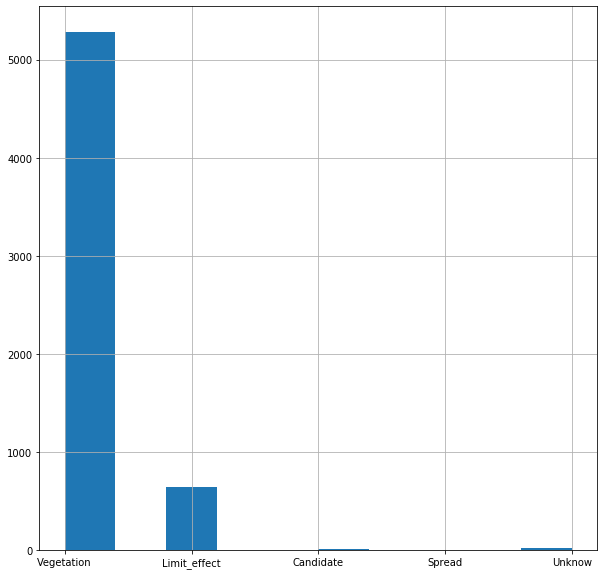

In [6]:
clusters.classification.hist()

As we can see we are handling a highly unbalanced dataset, having more than 95% of the instances not belonging to the interesting variable, Candidate or Spread.

In [7]:
correlations = np.zeros((len(numerical_columns), len(numerical_columns)))

for i1, c1 in enumerate(numerical_columns):
    for i2, c2 in enumerate(numerical_columns):
        correlations[i1, i2] = np.abs(pearsonr(data[c1], data[c2])[0])

## Pearson correlation coefficient among numerical variables

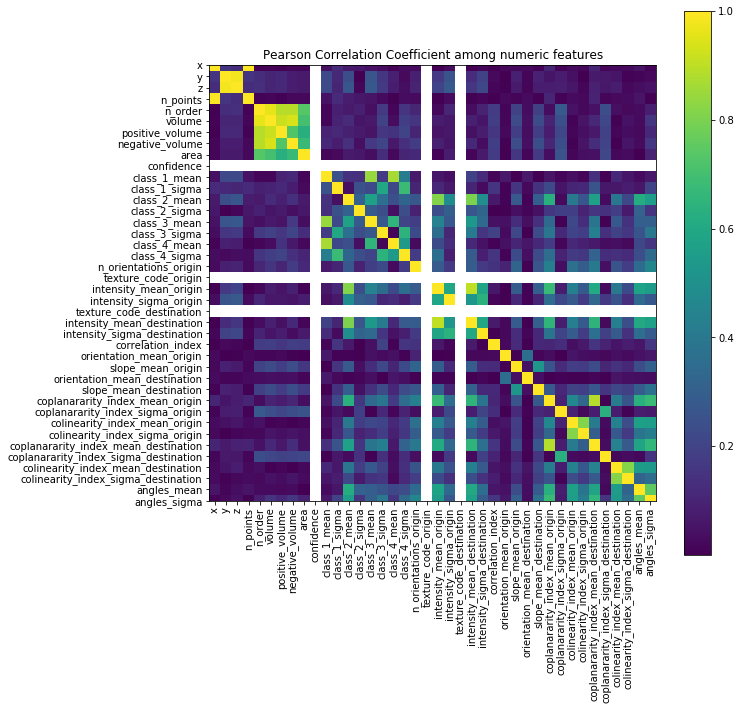

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(correlations, interpolation='nearest')

ax.set_title('Pearson Correlation Coefficient among numeric features')

plt.xticks(np.arange(len(numerical_columns)), numerical_columns, rotation='vertical')
plt.yticks(np.arange(len(numerical_columns)), numerical_columns)

ax.figure.colorbar(im, ax=ax)

There are several variables that are highly related, the features that are mean and standard deviation for example. Some variables have the same value always as confidence.

## Point biserial correlation among continous variables and correlation as Veg/~Veg

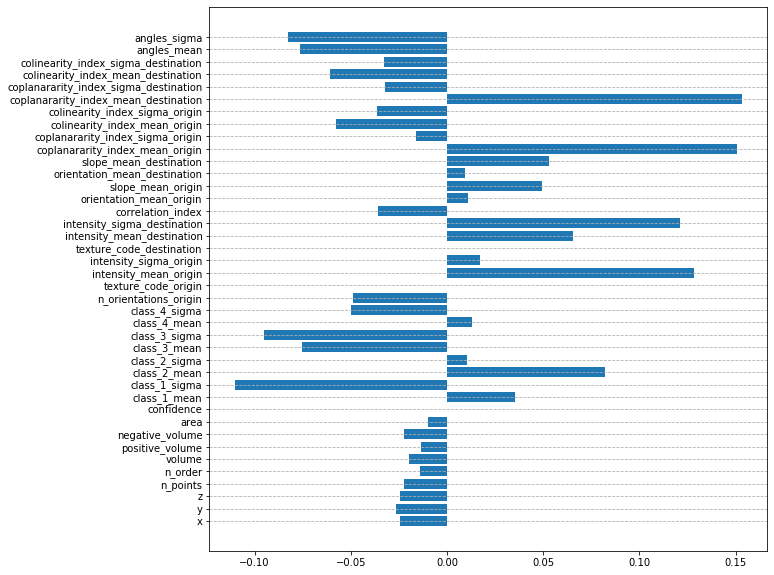

In [9]:
from scipy.stats import pointbiserialr

binary_class = ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))

correlations = np.zeros(len(numerical_columns))

for i, col in enumerate(numerical_columns):
    correlations[i] = pointbiserialr(data[col], binary_class)[0]
    
correlations[np.isnan(correlations)] = 0
plt.figure()
plt.barh(range(len(correlations)), correlations,align='center')
plt.yticks(np.arange(len(numerical_columns)), numerical_columns)
plt.grid(axis='y', linestyle='--')
pass

In [10]:
np.array(numerical_columns)[np.where(correlations > 0)]

array(['class_1_mean', 'class_2_mean', 'class_2_sigma', 'class_4_mean',
       'intensity_mean_origin', 'intensity_sigma_origin',
       'intensity_mean_destination', 'intensity_sigma_destination',
       'orientation_mean_origin', 'slope_mean_origin',
       'orientation_mean_destination', 'slope_mean_destination',
       'coplanararity_index_mean_origin',
       'coplanararity_index_mean_destination'], dtype=object)

## PCA

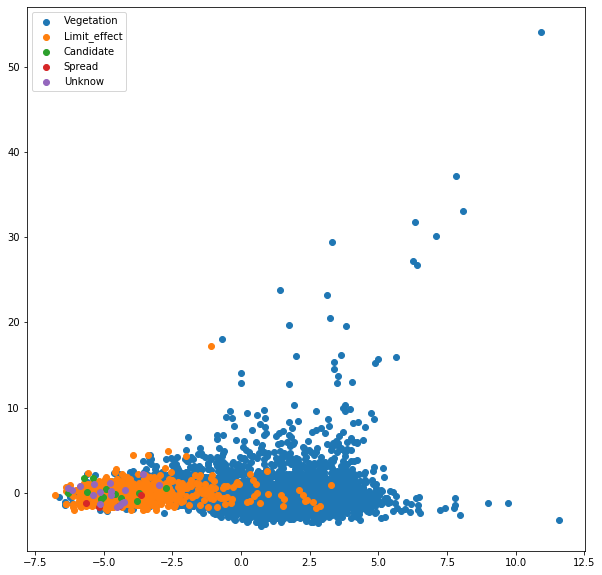

In [11]:
from sklearn.decomposition import PCA


X = data[numerical_columns].drop(
    ['confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)
X = (X - X.mean()) / X.std()
y = data['classification']

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

## PCA Binary

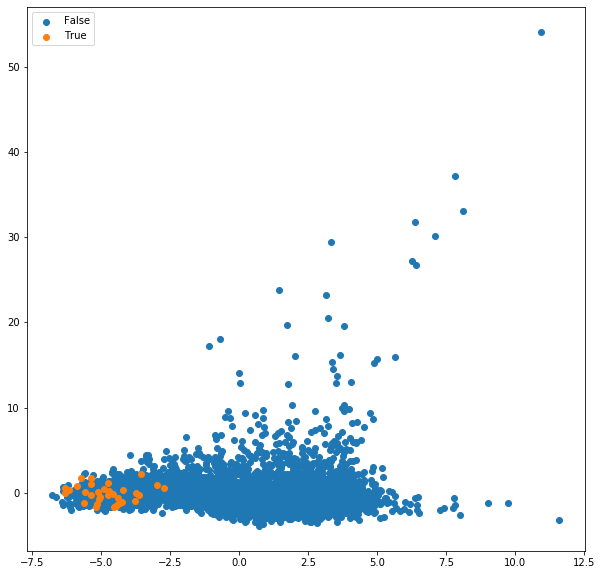

In [12]:
y = ((data['classification'] != 'Vegetation') & (data['classification'] != 'Limit_effect'))

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

## MDS Binary

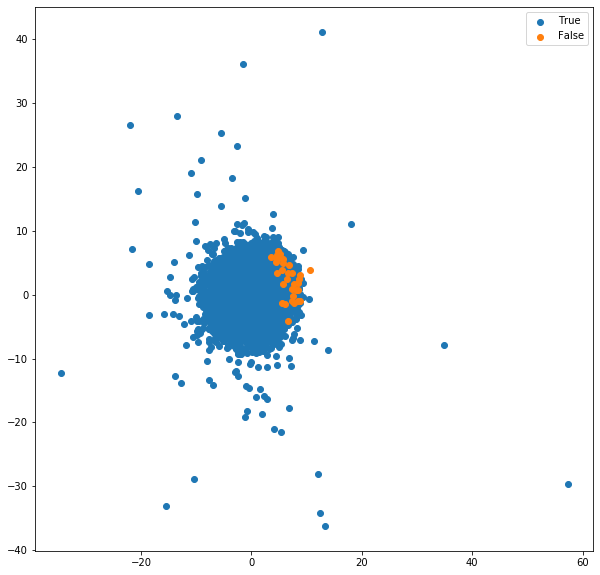

In [13]:
from sklearn.manifold import MDS


X = data[numerical_columns].drop(
    ['confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)
X = (X - X.mean()) / X.std()
y = ((data['classification'] == 'Vegetation') | (data['classification'] == 'Limit_effect'))

mds = MDS(n_components=2, n_jobs=-1)
transformed_data = mds.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

(-4.1464438663341205, 6.834417148308046)

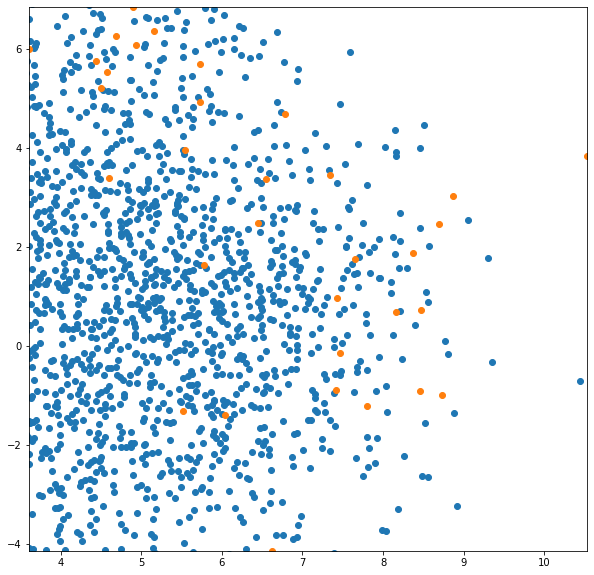

In [33]:
fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[cropped_y == classification].T, label=classification)
plt.xlim()

plt.xlim( (min(transformed_data[cropped_y == False][:, 0]),max(transformed_data[cropped_y == False][:, 0])))
plt.ylim( (min(transformed_data[cropped_y == False][:, 1]),max(transformed_data[cropped_y == False][:, 1])))

## TSNE Binary

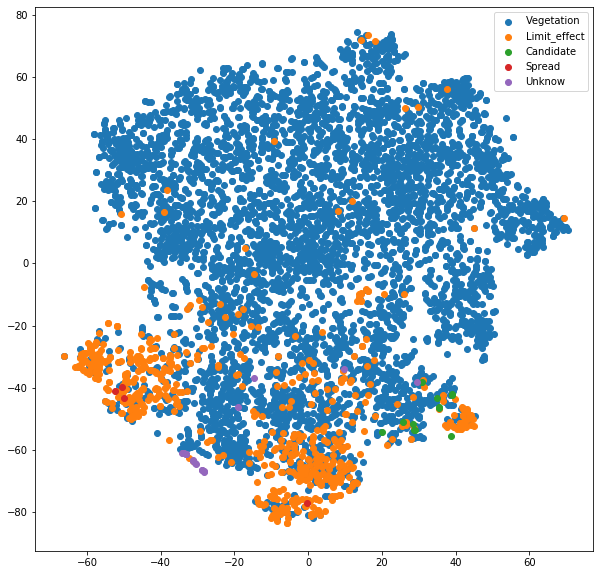

In [35]:
from sklearn.manifold import TSNE


X = data[numerical_columns].drop(
    ['confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)
X = (X - X.mean()) / X.std()
y = data['classification']

tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()